# <b>Importing Dataset <b>

In [1]:
import torch
import torch.nn as nn 
import torch.optim  as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision.models import squeezenet1_0, SqueezeNet1_0_Weights
from torch.optim import lr_scheduler
import numpy as np
import time
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
transform  = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(224),  # Image resizing to 224x224
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [3]:
PATH = "Potato-disease-classification"
data = datasets.ImageFolder(root=PATH , transform = transform)

In [4]:
data

Dataset ImageFolder
    Number of datapoints: 6666
    Root location: Potato-disease-classification
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [5]:
class_names = data.class_to_idx 
data.class_to_idx, data.classes

({'Potato Early blight': 0,
  'Potato Late blight': 1,
  'Potato healthy': 2,
  'potato crop': 3,
  'potato hollow heart': 4},
 ['Potato Early blight',
  'Potato Late blight',
  'Potato healthy',
  'potato crop',
  'potato hollow heart'])

In [6]:
data[0]

(tensor([[[ 0.6734,  0.6290,  0.5594,  ...,  1.0227,  1.1022,  1.1529],
          [ 0.3340,  0.3713,  0.4298,  ...,  0.9862,  1.0362,  1.0681],
          [-0.2348, -0.0605,  0.2126,  ...,  0.9251,  0.9256,  0.9259],
          ...,
          [-0.9577, -0.6397, -0.1416,  ...,  1.0166,  1.0242,  1.0291],
          [-0.1614, -0.2333, -0.3459,  ...,  1.0156,  1.0123,  1.0101],
          [ 0.3138,  0.0092, -0.4678,  ...,  1.0151,  1.0051,  0.9988]],
 
         [[ 1.0980,  1.0461,  0.9649,  ...,  1.0874,  1.1687,  1.2206],
          [ 0.7452,  0.7769,  0.8265,  ...,  1.0675,  1.1186,  1.1512],
          [ 0.1541,  0.3258,  0.5948,  ...,  1.0341,  1.0346,  1.0349],
          ...,
          [-0.7149, -0.4215,  0.0381,  ...,  1.1162,  1.1240,  1.1290],
          [ 0.1573,  0.0558, -0.1034,  ...,  1.1153,  1.1118,  1.1096],
          [ 0.6779,  0.3405, -0.1878,  ...,  1.1147,  1.1045,  1.0980]],
 
         [[ 0.0779,  0.0521,  0.0116,  ...,  1.4094,  1.4903,  1.5420],
          [-0.2388, -0.1814,

In [7]:
data[0][0].size()  # RGB 3 (224 , 224)

torch.Size([3, 224, 224])

# <b>Spliting it into Train and Test dataset<b>

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(data, test_size=0.2)

In [9]:
dataset_sizes = {'train': len(train_data) , 'test':len(test_data)}
len(train_data), len(test_data)

(5332, 1334)

In [10]:
training_data = DataLoader(train_data , batch_size = 64 , shuffle = True)
testing_data = DataLoader(test_data , batch_size = 64 , shuffle = True)
dataloaders = {"train":training_data, "test":testing_data}

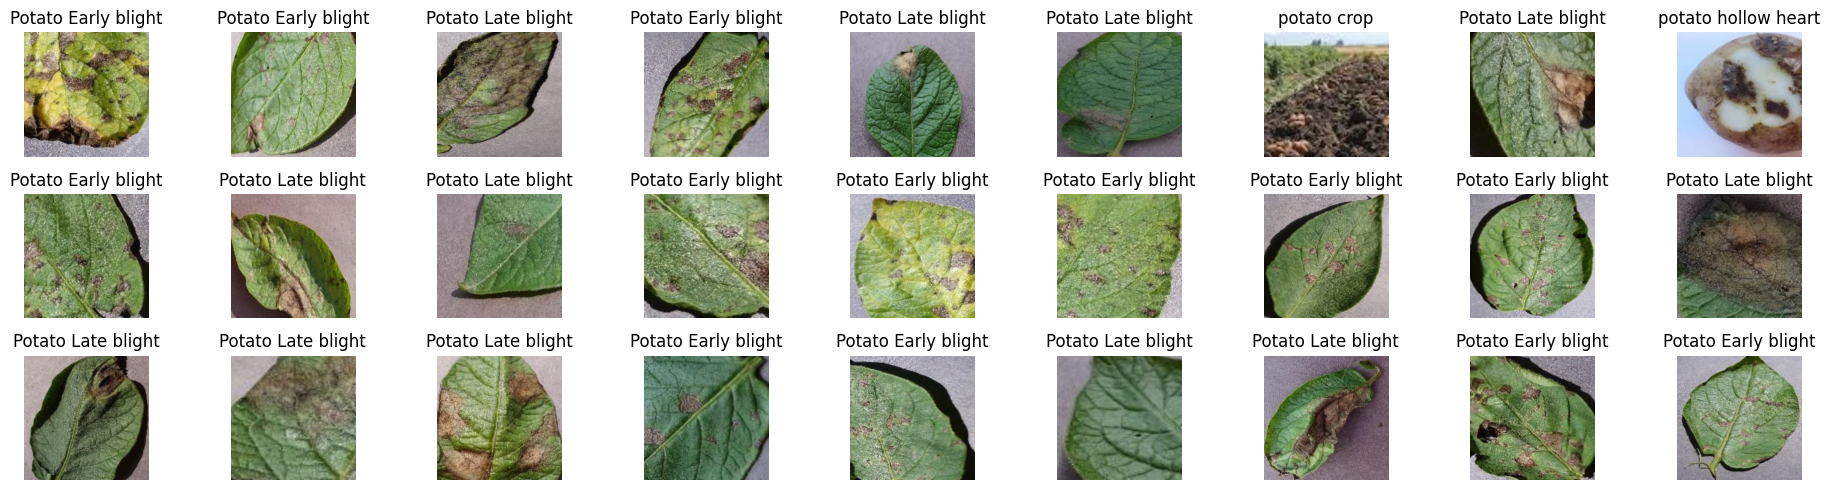

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline 
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).reshape(1, 1, 3)
    std = torch.tensor(std).reshape(1, 1, 3)
    return tensor * std + mean

row = 3
col = 9
fig, axs = plt.subplots(row, col, figsize=(col+10,5 )) 
axs = axs.flatten()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

for i in range(row*col):
    pixels = train_data[i][0]
    label = train_data[i][1]

    pixels = denormalize(pixels.permute(1, 2, 0), mean, std)
    pixels = torch.clamp(pixels, 0, 1)

    axs[i].imshow(pixels)
    axs[i].set_title(f'{data.classes[label]}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

# <b>Transfer Learning of SqueezeNet<b>

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = torch.as_tensor(labels).to(device)
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

### **Create function to visualize our model's predictions**

In [16]:
def visualize_predictions(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig, axs = plt.subplots(num_images // 2, 2, figsize=(10, 10))
    axs = axs.flatten()

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if images_so_far >= num_images:
                    break

                ax = axs[images_so_far]
                ax.axis('off')
                ax.set_title(f'Predicted: {data.classes[preds[j]]}') 
                imshow(inputs.cpu().data[j], ax)
                images_so_far += 1

            if images_so_far >= num_images:
                break

    for idx in range(images_so_far, num_images):
        axs[idx].axis('off')

    model.train(mode=was_training)

def imshow(tensor, ax):
    tensor = tensor.permute(1, 2, 0)
    tensor = torch.clamp(tensor, 0, 1)  # Clipping the tensor values to [0, 1]
    ax.imshow(tensor.numpy())


In [17]:
model_ft = squeezenet1_0(weights=SqueezeNet1_0_Weights.IMAGENET1K_V1)
model_ft.classifier[1] = nn.Conv2d(512, len(class_names), kernel_size=(1, 1), stride=(1, 1))
model_ft.num_classes = len(class_names)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001,momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to C:\Users\sagar/.cache\torch\hub\checkpoints\squeezenet1_0-b66bff10.pth
100.0%


In [18]:
model_ft

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [20]:
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs=10)

Epoch 1/10
----------
train Loss: 0.0994 Acc: 0.9649
test Loss: 0.1712 Acc: 0.9423

Epoch 2/10
----------
train Loss: 0.0606 Acc: 0.9764
test Loss: 0.0879 Acc: 0.9648

Epoch 3/10
----------
train Loss: 0.0470 Acc: 0.9826
test Loss: 0.0982 Acc: 0.9663

Epoch 4/10
----------
train Loss: 0.0451 Acc: 0.9831
test Loss: 0.0649 Acc: 0.9730

Epoch 5/10
----------
train Loss: 0.0286 Acc: 0.9906
test Loss: 0.0535 Acc: 0.9813

Epoch 6/10
----------
train Loss: 0.0250 Acc: 0.9917
test Loss: 0.0613 Acc: 0.9783

Epoch 7/10
----------
train Loss: 0.0117 Acc: 0.9966
test Loss: 0.0473 Acc: 0.9805

Epoch 8/10
----------
train Loss: 0.0108 Acc: 0.9966
test Loss: 0.0542 Acc: 0.9820

Epoch 9/10
----------
train Loss: 0.0101 Acc: 0.9959
test Loss: 0.0475 Acc: 0.9828

Epoch 10/10
----------
train Loss: 0.0106 Acc: 0.9961
test Loss: 0.0459 Acc: 0.9828

Training complete in 95m 2s
Best test Acc: 0.982759


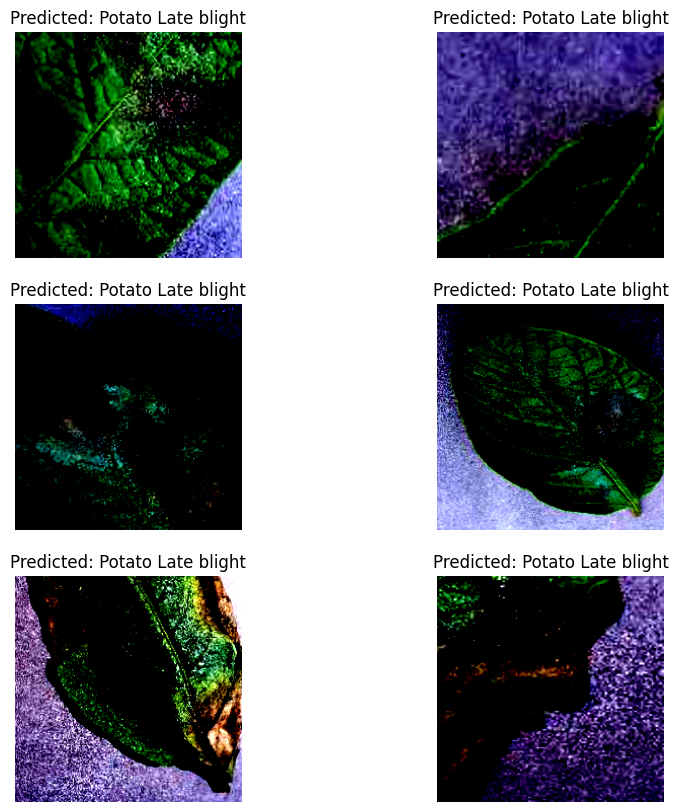

In [21]:
visualize_predictions(model_ft)